# Assignment 1


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

Using TensorFlow backend.
c:\users\robin\anaconda\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [3]:
#create co-occurrence matrix
import pandas as pd
from sklearn import preprocessing

#dataset with unique words as index
words = list(tokenizer.word_index.keys())
matrix = pd.DataFrame(words, columns=['words'])
matrix.set_index('words', inplace=True)
columns = pd.DataFrame(columns=words)
matrix = pd.concat([matrix,columns])
matrix = matrix.reindex(columns.columns, axis=1)
matrix.fillna(0, inplace=True)

#inverse index to get word by code
inverse_index = dict((v,k) for k, v in tokenizer.word_index.items())

#compute score for every word-word couple
for line in corpus:
    for i, word_code in enumerate(line):
        word = inverse_index.get(word_code)
        for j in range(max(0, i-window_size_corpus), min(len(line), i+window_size_corpus+1)):
            if word_code != line[j]:
                matrix[word][inverse_index.get(line[j])] += 1

#normalize each sample
normalized_values = preprocessing.normalize(matrix.values)
matrix = pd.DataFrame(normalized_values, index=matrix.index, columns=matrix.columns)

matrix.head()

,comfits,moment,pointing,seems,and,distance,day,after,own,life,...,remained,do,has,guessed,avoid,crocodile,position,called,hundred,key
comfits,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
moment,0.0,0.000000,0.0,0.0,0.222222,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
pointing,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
seems,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
and,0.0,0.014268,0.0,0.0,0.000000,0.014268,0.007134,0.028535,0.007134,0.014268,...,0.0,0.042803,0.014268,0.0,0.0,0.0,0.0,0.014268,0.0,0.042803


In [4]:
#find cosine similarity to Alice, Dinah and Rabbit

alice_vector = matrix['alice'].values.reshape(1, -1)
rabbit_vector = matrix['rabbit'].values.reshape(1, -1)
dinah_vector = matrix['dinah'].values.reshape(1, -1)

alice_vs_rabbit = cosine_similarity(alice_vector, rabbit_vector)
alice_vs_dinah = cosine_similarity(alice_vector, dinah_vector)
dinah_vs_rabbit = cosine_similarity(dinah_vector, rabbit_vector)

print("Cosine similarity between Alice and Rabbit: " + str(alice_vs_rabbit[0][0]))
print("Cosine similarity between Alice and Dinah: " + str(alice_vs_dinah[0][0]))
print("Cosine similarity between Dinah and Rabbit: " + str(dinah_vs_rabbit[0][0]))

Cosine similarity between Alice and Rabbit: 0.054617805224162
Cosine similarity between Alice and Dinah: 0.05073318700003422
Cosine similarity between Dinah and Rabbit: 0.034243448025346485


In [5]:
#find the closest words to Alice (nearest neighbors)

neigh = nn()
neigh.fit(matrix.values)

neighbors = neigh.kneighbors(alice_vector, 6)

for i, n in enumerate(neighbors[1][0]):
    if matrix.index[n] != 'alice':
        print("Word: {}\nDistance: {}\n".format(matrix.index[n], neighbors[0][0][i]))

Word: i
Distance: 3.6581715798218193

Word: she
Distance: 3.662735140275419

Word: a
Distance: 3.664105104961175

Word: very
Distance: 3.665855124516278

Word: it
Distance: 3.66876538790552



The five closest words to "Alice" appear to be: "I", "she", "a", "very" and "it". It makes sense that the personal pronouns "she" and "i" are the closest ones to "Alice", since they are used in very similiar contexts and they are probably often followed by the same verbs. E.g. "Alice sees the rabbit", "she sees the rabbit" or "I see the rabbit", in direct dialogs. As for the other three words, they do not bring valuable information, as they are all quite common in the english language. A possible way to avoid this would be to remove stopwords from the corpus, in order to focus only on more meaningful terms.

Discussion of the drawbacks:
- **Sparse matrix:** As can be seen in the output of the matrix, the word pair 'particular' and 'suddenly' never appear close to each other in the corpus, but there is still a cell reserved in the matrix for that pair. The same goes for many other pairs in the matrix, resulting in many cells with value 0. Obviously, this is not very efficient for storage.
- **Large matrix:** As can be seen in the word co-occurrence matrix for Alice In Wonderland that was created above, the matrix size is 1182 rows x 1182 columns, where 1182 is the number of tokens in the corpus. It is easy to imagine that this will become a problem for a bigger corpus, or for a corpus which has dynamic content, e.g. a web search engine.
- **Non-discriminative results:** As shown in the nearest neighbors calculation above, the words 'a', 'it', and 'very' do not give very meaningful correlation. However, they are among the most common words used in English language, so it makes sense that they appear often near the term 'Alice' (or any other terms in the corpus). Therefore, stopwords filter or even a different weighting score other than word occurence count should be used in order to find words correlation that is more meaningful.

In [6]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = matrix.values
for i, word in enumerate(tokenizer.word_index.keys()): 
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [7]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [96]:
#function definitions for CBOW

#generate data for CBOW
def generate_data_cbow(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            
            all_in.append(sequence.pad_sequences(contexts, maxlen=maxlen))
            all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

#load the preprocessed CBOW data
def generate_data_cbow_from_file():
    f = open('data_cbow.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ').reshape(1,-1)
        outputs = np.fromstring(outputs, dtype=float, sep=' ').reshape(1,-1)
        yield (inputs,outputs)

In [93]:
#prepare data for cbow
   
#get x and y's for data
x,y = generate_data_cbow(corpus,window_size,V)

#save the preprocessed data of CBOW
f = open('data_cbow.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [97]:
#create CBOW model

for dim in [50, 150, 300]:
    #create model
    cbow = Sequential()
    cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
    cbow.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for CBOW
    cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')
    
    #train CBOW model
    print("\nTraining cbow for dim="+str(dim))
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_cbow_from_file():
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)
    
    #save vector representation to file
    f = open('vectors_cbow_'+str(dim)+'.txt' ,'w')
    f.write(" ".join([str(V-1),str(dim)]))
    f.write("\n")

    vectors = cbow.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()


Training cbow for dim=50
0 41683.3370244503

Training cbow for dim=150
0 41635.21488714218

Training cbow for dim=300
0 41557.85131263733


In [31]:
#function definitions for Skipgram

#generate data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [32]:
#prepare data for Skipgram
   
#get x and y's for data
x,y = generate_data_skipgram(corpus,window_size,V)

#save the preprocessed data of Skipgram
f = open('data_skipgram.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [43]:
#create Skipgram model

for dim in [50, 150, 300]:
    #create model
    skipgram = Sequential()
    skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
    skipgram.add(Reshape((dim, )))
    skipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for Skipgram
    skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')
    
    #train skipgram model
    print("\nTraining skipgram for dim="+str(dim))
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_skipgram_from_file():  
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    
    #save vector representation to file
    f = open('vectors_skipgram_'+str(dim)+'.txt' ,'w')
    f.write(" ".join([str(V-1),str(dim)]))
    f.write("\n")

    vectors = skipgram.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()


Training skipgram for dim=50


KeyboardInterrupt: 

In [111]:
#create CBOW model with additional dense layer

for dim in [50, 150, 300]:
    #create model
    cbow = Sequential()
    cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
    cbow.add(Dense(128, activation="relu"))
    cbow.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for CBOW + dense
    cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')
    
    #train CBOW + dense model
    print("\nTraining cbow for dim="+str(dim))
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_cbow_from_file():
            loss += cbow.train_on_batch(x, y)
        print(ite, loss)
    
    #save vector representation to file
    f = open('vectors_cbow_dense_'+str(dim)+'.txt' ,'w')
    f.write(" ".join([str(V-1),str(dim)]))
    f.write("\n")

    vectors = cbow.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()


Training cbow for dim=50
0 39892.682822823524

Training cbow for dim=150
0 39837.6227093339

Training cbow for dim=300
0 39748.12102890015


In [ ]:
#create Skipgram model with additional dense layer

for dim in [50, 150, 300]:
    #create model
    skipgram = Sequential()
    skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
    skipgram.add(Reshape((dim, )))
    skipgram.add(Dense(128, activation="relu"))
    skipgram.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for Skipgram + dense
    skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')
    
    #train model for Skipgram + dense
    print("\nTraining skipgram with dense layer for dim="+str(dim))
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_skipgram_from_file():
            loss += skipgram.train_on_batch(x, y)
        print(ite, loss)
    
    #save vector representation to file
    f = open('vectors_skipgram_dense_'+str(dim)+'.txt' ,'w')
    f.write(" ".join([str(V-1),str(dim)]))
    f.write("\n")

    vectors = skipgram.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()

In [112]:
#load vectors from files
cbows = []
cbows_dense = []
skipgrams = []
skipgrams_dense = []
    
for dim in [50, 150, 300]:
    f = open('vectors_skipgram_'+str(dim)+'.txt' ,'r')
    d = {}
    for row in f.readlines()[1:]:
        line = row.split()
        d[line[0]] = line[1:]
    skipgrams.append(d)
    
    f = open('vectors_skipgram_dense_'+str(dim)+'.txt' ,'r')
    d = {}
    for row in f.readlines()[1:]:
        line = row.split()
        d[line[0]] = line[1:]
    skipgrams_dense.append(d)
    
    f = open('vectors_cbow_'+str(dim)+'.txt' ,'r')
    d = {}
    for row in f.readlines()[1:]:
        line = row.split()
        d[line[0]] = line[1:]
    cbows.append(d)
    
    f = open('vectors_cbow_dense_'+str(dim)+'.txt' ,'r')
    d = {}
    for row in f.readlines()[1:]:
        line = row.split()
        d[line[0]] = line[1:]
    cbows_dense.append(d)
    
#save as separate dictionaries
skipgram_vectors_50 = skipgrams[0]
skipgram_vectors_150 = skipgrams[1]
skipgram_vectors_300 = skipgrams[2]
skipgram_dense_vectors_50 = skipgrams_dense[0]
skipgram_dense_vectors_150 = skipgrams_dense[1]
skipgram_dense_vectors_300 = skipgrams_dense[2]
cbow_vectors_50 = cbows[0]
cbow_vectors_150 = cbows[1]
cbow_vectors_300 = cbows[2]
cbow_dense_vectors_50 = cbows_dense[0]
cbow_dense_vectors_150 = cbows_dense[1]
cbow_dense_vectors_300 = cbows_dense[2]

In [113]:
#Implement your own analogy function
def analogy_function(dictionary):
    scores = []
    f = open('analogy_alice.txt' ,'r')
    for row in f:
        line = row.split()
        if all(x in dictionary for x in line):
            A = np.array(dictionary[line[0]], dtype=float)
            B = np.array(dictionary[line[1]], dtype=float)
            C = np.array(dictionary[line[2]], dtype=float)
            D = np.array(dictionary[line[3]], dtype=float)        
            scores.append(cosine_similarity((A - B + C).reshape(1, -1),D.reshape(1, -1))[0][0])
            
    return sum(scores)/len(scores)

        
#skipgram score
skipgram_50_score = analogy_function(skipgram_vectors_50)
print("Analogy score for Skipgram model with dim=50: " + str(skipgram_50_score))
skipgram_150_score = analogy_function(skipgram_vectors_150)
print("Analogy score for Skipgram model with dim=150: " + str(skipgram_150_score))
skipgram_300_score = analogy_function(skipgram_vectors_300)
print("Analogy score for Skipgram model with dim=300: " + str(skipgram_300_score))
print()

#skipgram + dense scores
skipgram_dense_50_score = analogy_function(skipgram_dense_vectors_50)
print("Analogy score for Skipgram + dense model with dim=50: " + str(skipgram_dense_50_score))
skipgram_dense_150_score = analogy_function(skipgram_dense_vectors_150)
print("Analogy score for Skipgram + dense model with dim=150: " + str(skipgram_dense_150_score))
skipgram_dense_300_score = analogy_function(skipgram_dense_vectors_300)
print("Analogy score for Skipgram + dense model with dim=300: " + str(skipgram_dense_300_score))
print()

#cbow score
cbow_50_score = analogy_function(cbow_vectors_50)
print("Analogy score for CBOW model with dim=50: " + str(cbow_50_score))
cbow_150_score = analogy_function(cbow_vectors_150)
print("Analogy score for CBOW model with dim=150: " + str(cbow_150_score))
cbow_300_score = analogy_function(cbow_vectors_300)
print("Analogy score for CBOW model with dim=300: " + str(cbow_300_score))
print()

#skipgram + dense scores
cbow_dense_50_score = analogy_function(cbow_dense_vectors_50)
print("Analogy score for CBOW + dense model with dim=50: " + str(cbow_dense_50_score))
cbow_dense_150_score = analogy_function(cbow_dense_vectors_150)
print("Analogy score for CBOW + dense model with dim=150: " + str(cbow_dense_150_score))
cbow_dense_300_score = analogy_function(cbow_dense_vectors_300)
print("Analogy score for CBOW + dense model with dim=300: " + str(cbow_dense_300_score))
print()

Analogy score for Skipgram model with dim=50: 0.1538180261626648
Analogy score for Skipgram model with dim=150: 0.09847292209927096
Analogy score for Skipgram model with dim=300: 0.07711539410906129

Analogy score for Skipgram + dense model with dim=50: -0.0020859167319388513
Analogy score for Skipgram + dense model with dim=150: -0.02795878829116236
Analogy score for Skipgram + dense model with dim=300: -0.0003669102820264841

Analogy score for CBOW model with dim=50: -0.06011167176264178
Analogy score for CBOW model with dim=150: -0.009195730215878401
Analogy score for CBOW model with dim=300: -0.039612704663031705

Analogy score for CBOW + dense model with dim=50: -0.03349581699008332
Analogy score for CBOW + dense model with dim=150: -0.008301053846080722
Analogy score for CBOW + dense model with dim=300: -0.012552925822494993



**Comparison performance**

In the analogy function defined above, we test the analogy calculation of 3 terms, i.e. A-B+C=D, by taking the vector of the expected answer, i.e. D, from the tested model, and then calculating how close is it with the actual vector result of A-B+C, using cosine similarity. The analogies used in the calculation are taken from the file "analogy_alice.txt". The analogy score is then defined as the average of cosine similarity score between the expected and the actual vector of the analogy calculations.

Looking at the results above, we can conclude that a Skipgram model with 50 dimensions gives the best analogy results. It gives analogy score of 0.15 - which is not very high - but it is the closest to 1, which means that more analogy calculation results are similar to the expected answer compared to the other Skipgram models (with and without dense layers).

_TODO: add comparison with CBOW models_

In [114]:
#Comparison to the co-occurrance matrix embeddings
f = open('analogy_alice.txt' ,'r')
matrix_scores = []

for row in f:
    line = row.split()
    if all(x in matrix for x in line):
        A = np.array(matrix[line[0]].values, dtype=float)
        B = np.array(matrix[line[1]].values, dtype=float)
        C = np.array(matrix[line[2]].values, dtype=float)
        D = np.array(matrix[line[3]].values, dtype=float)
        matrix_scores.append(cosine_similarity((A - B + C).reshape(1, -1),D.reshape(1, -1))[0][0])
    
#matrix scores
matrix_score = sum(matrix_scores)/len(matrix_scores)
print("Analogy score for co-occurrance matrix: " + str(matrix_score))

Analogy score for co-occurrance matrix: -0.0032230167361160843


,50,150,300
Skipgram,0.153818,0.098473,0.077115
Skipgram + dense,-0.002086,-0.027959,-0.000367
CBOW,-0.060112,-0.009196,-0.039613
CBOW + dense,-0.033496,-0.008301,-0.012553
Co-occurrance matrix,-0.003223,-0.003223,-0.003223


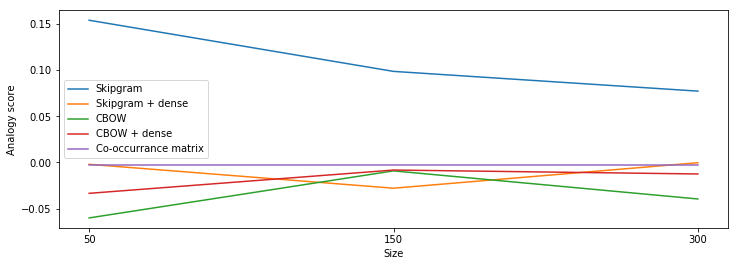

In [115]:
#Visualization results trained word embeddings
import matplotlib.pyplot as plt

scores = pd.DataFrame(columns=["50","150","300"])
scores.loc["Skipgram"] = [skipgram_50_score, skipgram_150_score, skipgram_300_score]
scores.loc["Skipgram + dense"] = [skipgram_dense_50_score, skipgram_dense_150_score, skipgram_dense_300_score]
scores.loc["CBOW"] = [cbow_50_score, cbow_150_score, cbow_300_score]
scores.loc["CBOW + dense"] = [cbow_dense_50_score, cbow_dense_150_score, cbow_dense_300_score]
scores.loc["Co-occurrance matrix"] = [matrix_score, matrix_score, matrix_score]
display(scores)

scores = scores.T
scores = scores.reindex(scores.index.rename('Size'))
ax = scores.plot(figsize=(12,4))
ax.set_xticks(range(0, 3))
ax.set_xticklabels(scores.index)
plt.ylabel('Analogy score')
plt.legend(loc='best');

**Interpretation results of the visualization**

From the visualization above, we can see that the analogy score of Skipgram, and Skipgram models with dense layers initially have relatively big difference. However, the more dimensions are included in either types, the closer the analogy score seems to converge. Nevertheless, it seems like increasing the dimensionality of (dense) Skipgram models in general results in less accurate analogy calculations.

_TODO: add analysis of CBOW models_

**Compare the results of the trained word embeddings with the word-word co-occurrence matrix**

All Skipgram models seem to perform better than Co-occurrence matrix, except the 150-dimensions Skipgram with dense layers.

*TODO: compare co-occurrence matrix with CBOW models*

**Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram**

In [ ]:
#load pretrained word embeddings of word2vec

path_word2vec = "../GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [ ]:
#load pretraind word embeddings of Glove
from gensim.scripts import glove2word2vec

path = "../glove.6B/glove.6B.300d.txt"
glove_file_name = "glove_converted.txt"

#convert GloVe into word2vec format
num_vectors, num_dims = glove2word2vec.get_glove_info(path)
glove2word2vec.glove2word2vec(path, glove_file_name)

line = "{} {}".format(num_vectors, num_dims)
with open(glove_file_name, 'r+', encoding='utf-8') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [ ]:
#Visualize the pre-trained word embeddings

Comparison performance with your own trained word embeddings